In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import numpy as np
import numpy.random as rnd
import scipy.stats as stats
from scipy.special import logsumexp, digamma
import seaborn as sns
from typing import *


plt.style.use("ggplot")
sns.set_context("poster")

各分布のハイパーパラメーターなどを保持するクラスを作る。

In [2]:
class Gamma:
    def __init__(self, *, a, b):
        self.a = a
        self.b = b
        
    def get():
        """ ガンマ分布をscipyのfrozen RV objectの形で返す。
        Notes:
            scipyのgamma distは、教科書の定義とちょっと異なる。教科書で言うハイパーパラメーターbは、
            scaleという名前で指定する。
            https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html
        """
        return [stats.gamma(a=elem, scale=b) for elem in self.a]


class Poisson:
    def __init__(self, *, lambda_: List[float]):
        self.lambda_ = lambda_

    def get():
        """ ポアソン分布をscipyのfrozen RV objectの形で返す。"""
        return [stats.poisson(mu=elem) for elem in self.lambda_]


class BayesPoiMixModel:
    def __init__(self, *, num_dim: int, num_cluster: int, alpha, gamma):
        """ ポアソン混合モデルの事前・事後分布を表現するクラスを構築する。
        Args:
            D: 観測データの次元
            K: クラスター数
            alpha : カテゴリ分布のパラメーター $\pi$ の共役事前分布であるディリクレ分布のハイパーパラメーター (p.119)
            gamma : ポアソン分布のパラメーター $\lambda$ の共役事前分布であるガンマ分布のハイパーパラメーター (p.129)
                * 非リストを指定した場合、全クラスターに同じ値を指定する。
                * リストを指定した場合、各クラスターにおのおの指定された値を指定する。
        Notes:
            len(gamma) != num_clusterの場合は例外を投げる。
        """
        self.num_dim = num_dim
        self.num_cluster = num_cluster
        self.alpha = np.ones(num_cluster) * alpha
        if isinstance(gamma, list):
            if len(gamma) != num_cluster:
                raise "in BayesPoiMixModel.__init__() : len(gamma) != num_cluster"
            self.gamma = gamma
        else: 
            self.gamma = [gamma]*num_cluster


class PoiMixModel:
    def __init__(self, *, num_dim: int, num_cluster: int, phi, poisson: Poisson):
        """ 真のポアソン混合モデルを構築する。
        Args:
            D: 観測データの次元
            K: クラスター数
            alpha : 
            poiDists: 
        """
        self.num_dim = num_dim
        self.num_cluster = num_cluster
        self.phi = phi
        if isinstance(poisson, list):
            if len(poisson) != num_cluster:
                raise "in PoiMixModel.__init__() : len(poisson) != num_cluster"
            self.poisson = poisson
        else: 
            self.poisson = [poisson]*num_cluster

ユーティリティ関数を定義する。

In [3]:
def calc_ELBO(X, prior: BayesPoiMixModel, posterior: BayesPoiMixModel): # X: Mat{float}
    """ ELBOを計算する。付録A.4を参照のこと。
    Args:
        X: 
        prior: 
        posterior: 
    """
    ln_expt_S = update_S(posterior, X)
    expt_S = np.exp(ln_expt_S)
    K, N = expt_S.shape
    D = X.shape[0]

    expt_ln_lambda = np.zeros(S.shape) #np.matrix(np.zeros(D, K))
    expt_lambda = np.zeros(S.shape) #np.matrix(np.zeros(D, K))
    expt_ln_lkh = 0
    for k in range(K):
        expt_ln_lambda[:,k] = digamma(posterior.gamma[k].a) - np.log(posterior.gamma[k].b)
        expt_lambda[:,k] = posterior.gamma[k].a / pos.gamma[k].b
        for n in range(N):
            expt_ln_lkh += expt_S[k,n] * (
                X[:, n].T * expt_ln_lambda[:,k] 
                    - sum(expt_lambda[:,k]) - sum(np.lgamma(X[:,n]+1))
            )[1]

    expt_ln_pS = sum(expt_S.T * (digamma(posterior.alpha) - digamma(sum(posterior.alpha))))
    expt_ln_qS = sum(expt_S * ln_expt_S)
    KL_lambda = 0
    for k in range(K):
        KL_lambda += (
            sum(posterior.gamma[k].a)*np.log(posterior.gamma[k].b) 
                - sum(prior.gamma[k].a)*np.log(prior.gamma[k].b)
                - sum(np.lgamma(posterior.gamma[k].a)) + sum(np.lgamma(prior.gamma[k].a))
                + (posterior.gamma[k].a - prior.gamma[k].a).T * expt_ln_lambda[:,k]
                + (prior.gamma[k].b - posterior.gamma[k].b) * sum(expt_lambda[:,k])
        )[1]
    
    KL_pi = (
        np.lgamma(sum(posterior.alpha)) 
            - np.lgamma(sum(prior.alpha))
            - sum(np.lgamma(posterior.alpha)) + sum(np.lgamma(prior.alpha))
            + (posterior.alpha - prior.alpha).T 
        * (digamma(posterior.alpha) - digamma(sum(posterior.alpha)))
    )[1]
    return expt_ln_lkh + expt_ln_pS - expt_ln_qS - (KL_lambda + KL_pi)


def add_stats(bpmm: BayesPoiMixModel, X, S):  # X: Matrix{Float64}, S: Matrix{Float64}
    D = bpmm.num_dim
    K = bpmm.num_cluster
    sum_S = sum(S, 2)
    alpha = [bpmm.alpha[k] + sum_S[k] for k in range(K)]
    gamDists = [] # Vector{Gam}()
    XS = X @ S.T;
    for k in range(K):
        a = [float(bpmm.gamma[k].a[d] + XS[d,k]) for d in range(D)]
        b = bpmm.gamma[k].b + sum_S[k]
        gamDists.append(Gamma(a=a, b=b))
    return BayesPoiMixModel(num_dim=D, num_cluster=K, alpha=alpha, gamma=gamDists)


def remove_stats(bpmm: BayesPoiMixModel, X, S): # X: Matrix{Float64}, S: Matrix{Float64}
    return add_stats(bpmm, X, -S)

In [4]:
# Sample a PMM given hyperparameters.
def sample_PMM(bpmm: BayesPoiMixModel) -> PoiMixModel:
    pois = []
    for c in bpmm.gamma:
        lambda_ = np.zeros(bpmm.num_dim)
        for d in range(bpmm.num_dim):
            lambda_[d] = rnd.gamma(shape=c.a[d], scale=1.0/c.b)
        pois.append(Poisson(lambda_ = lambda_))
    return PoiMixModel(
        num_dim = bpmm.num_dim, 
        num_cluster = bpmm.num_cluster,
        phi = rnd.dirichlet(bpmm.alpha),
        poisson=pois
    )


# Sample data from a specific PMM model.
def sample_data(pmm: PoiMixModel, N: int):
    x = np.zeros((pmm.num_dim, N)) #np.matrix(np.zeros(pmm.D, N))
    s = categorical_sample(pmm.phi, N)
    for n in range(N):
        k = np.argmax(s[:, n])
        for d in range(pmm.num_dim):
            x[d, n] = rnd.poisson(pmm.poisson[k].lambda_[d])
    return x, s

#categorical_sample(p::Vector{Float64}) = categorical_sample(p, 1)[:,1]

def categorical_sample(p: List[float], N: int = 1):
    K = len(p)
    S = np.zeros((K, N)) # np.matrix(np.zeros(K, N))
    # numpy.randomにはわかりやすくcategorical sampleを行う関数がない。
    # ググったところ、numpy.random.Generator.choice()がカテゴリ分布になっているらしい。
    # http://bois.caltech.edu/distribution_explorer/discrete/categorical.html
    S_tmp = rnd.default_rng().choice(len(p), N, p=p)
    for k in range(K):
        #S[S[k, S_tmp == k]] = 1
        #S[k,find(S_tmp==k)] = 1
        S[k, S_tmp == k] = 1
    return S if N != 1 else S[:, 0]


def init_S(x, bpmm: BayesPoiMixModel): # X: Matrix{float}
    s = categorical_sample(np.ones(bpmm.num_cluster)/bpmm.num_cluster, x.shape[1])    
    return s

ギブスサンプリングを実装する。

In [5]:
# used for Gibbs Sampling
def sample_S_GS(pmm: PoiMixModel, X):  # X: Matrix{Float64}
    D, N = X.shape
    K = pmm.num_cluster
    S = np.zeros((K, N))
    tmp = [-sum(pmm.poisson[k].lambda_) + np.log(pmm.phi[k]) for k in range(K)]
    ln_lambda_X = [X.T*np.log(pmm.poisson[k].lambda_) for k in range(K)]
    for n in range(N):
        tmp_ln_phi = [(tmp[k] + ln_lambda_X[k][n]) for k in range(K)]
        # 知らなかったのでメモ：詳細は https://qiita.com/BigSea/items/1949b3ceefcec4fc32ea
        # logsumexp()ってなんだよlog(sum(exp(.)))でええやん、、、？みたいな気持ちになるが、
        # log(sum(exp(.)))した結果はアンダー・オーバーフローしない範囲に収まっていても、
        # exp(.)の時点でアンダー・オーバーフローしたら全てがおじゃんなので、これを回避するための計算法
        # （面白い；実際書き下して回したらアンダーフローした、そりゃそうだ）
        tmp_ln_phi = tmp_ln_phi - logsumexp(tmp_ln_phi)
        S[:,n] = categorical_sample(np.exp(tmp_ln_phi).T[0,:])
    return S


def conduct_Gibbs_sampling(x, s, prior: BayesPoiMixModel):  # X::Matrix{Float64}
    # sample parameters
    pmm = sample_PMM(prior)
    # sample latent variables
    s = sample_S_GS(pmm, x)
    # update current model
    bpmm = add_stats(prior, x, s)
    return s, bpmm, calc_ELBO(x, prior, bpmm)

変分推論を実装する。

In [6]:
# Compute posterior distribution via variational inference.
def update_S(prior: BayesPoiMixModel, x):
    D, N = x.shape
    num_cluster = prior.num_cluster
    ln_expt_S = np.zeros((num_cluster, N))
    tmp = np.zeros(num_cluster)

    sum_digamma_tmp = digamma(sum(bpmm.alpha))
    for k in range(num_cluster):
        tmp[k] = - sum(bpmm.cmp[k].a) / bpmm.cmp[k].b
        tmp[k] += digamma(bpmm.alpha[k]) - sum_digamma_tmp
    ln_lambda_X = [x.T*(digamma(bpmm.cmp[k].a) - np.log(bpmm.cmp[k].b)) for k in range(num_cluster)]
    for n in range(N):
        tmp_ln_pi =  [tmp[k] + ln_lambda_X[k][n] for k in range(K)]
        ln_expt_S[:,n] = tmp_ln_pi - logsumexp(tmp_ln_pi)
    return ln_expt_S


def conduct_variational_inference(x, s, prior_bpmm: BayesPoiMixModel):  # X: Matrix{Float64}
    """ 変分推論により事後分布を推定する。
    """
    # E-step
    expt_S = np.exp(update_S(bpmm, x))
    # M-step
    posterior = add_stats(prior, x, expt_S)
    return expt_S, bpmm, calc_ELBO(x, prior, posterior)

崩壊型ギブスサンプリングを実装する。

In [7]:
# used for Collapsed Gibbs Sampling
def calc_ln_NB(Xn, gam: Gamma): # Xn: Vector{Float64}
    return sum([
        float(gam.a[d]*np.log(gam.b)
            - np.lgamma(gam.a[d])
            + np.lgamma(Xn[d] + gam.a[d])
            - (Xn[d] + gam.a[d])*np.log(gam.b + 1)
        ) for d in range(Xn.shape[0])
    ])


def sample_Sn(Xn, bpmm: BayesPoiMixModel): # Xn: Vector{Float64}
    ln_tmp = [(calc_ln_NB(Xn, bpmm.cmp[k]) + np.log(bpmm.alpha[k])) for k in range(bpmm.K)]
    ln_tmp = ln_tmp -  logsumexp(ln_tmp)
    Sn = categorical_sample(np.exp(ln_tmp))
    return Sn


def sample_S_CGS(S, M, bpmm: BayesPoiMixModel):  # S: Matrix{Float64}, X: Matrix{Float64}
    D, N = X.shape
    K = S.shape[0]
    for n in randperm(N):
        bpmm = remove_stats(bpmm, X[:,[n]], S[:,[n]])  # remove
        S[:,n] = sample_Sn(X[:,n], bpmm)  # sample
        bpmm = add_stats(bpmm, X[:,[n]], S[:,[n]])  # insert
    return S, bpmm


def conduct_collapsed_Gibbs_sampling(x, s, prior: BayesPoiMixModel):  
    # directly sample S
    s, posterior = sample_S_CGS(s, x, prior)
    return s, bpmm, calc_ELBO(x, prior, posterior)

指定されたアルゴリズムをstep-by-stepに実行していくwrapperを作っておく。

In [8]:
algorithms = {
    "GS": conduct_Gibbs_sampling, 
    "VI": conduct_variational_inference, 
    "CGS": conduct_collapsed_Gibbs_sampling,
}


def learn_step_by_step(x, s, prior: BayesPoiMixModel, algo: str):
    return algorithms[algo](x, s, prior)


class Cache:
    def __init__(self, x, s, prior):
        self.x = x
        self.s = s
        self.prior = prior


def learn(x, s, prior: BayesPoiMixModel, iter_=1000):
    # 初期化
    s = init_S(x, prior)
    prior = add_stats(prior, x, s)
    
    # 各アルゴリズムの結果をキャッシュしておく変数を作る
    gs, vi, cgs = Cache(x, s, prior), Cache(x, s, prior), Cache(x, s, prior)
    for i in range(iter_):
        gs = learn_step_by_step(gs.x, gs.s, gs.prior, "GS")
        vi = learn_step_by_step(vi.x, vi.s, vi.prior, "VI")
        cgs = learn_step_by_step(cgs.x, cgs.s, cgs.prior, "CGS")
    
    return gs, vi, cgs

モデルを作って、クラスタリングを行うデータを見てみる。

(array([182., 182.,  51.,  36., 100., 191., 145.,  76.,  25.,  12.]),
 array([ 0. ,  3.2,  6.4,  9.6, 12.8, 16. , 19.2, 22.4, 25.6, 28.8, 32. ]),
 <a list of 10 Patch objects>)

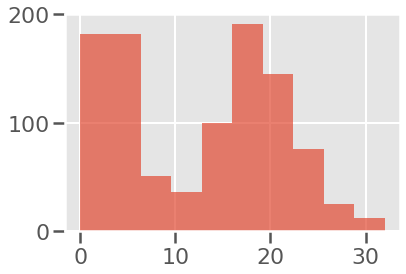

In [29]:
# モデルの構築
prior_ = BayesPoiMixModel(
    num_dim=1, 
    num_cluster=2, 
    alpha=100.0, 
    gamma=Gamma(a=1.0*np.ones(1), b=0.01)
)

pmm_ = sample_PMM(prior_)  # 真のモデルを作る
x_, s_ = sample_data(pmm_, 1000)  # データを作る
plt.hist(x_[0, :], alpha=.7)

ざっくりと2峰性の分布になっていることがわかる。このデータに対してクラスタリングを行ってみる。

In [10]:
results = learn(x_, s_, prior_, iter_=1000)

NameError: name 'bpmm' is not defined